# TASK A. Binary Task with the Aid of SVM

## Importing the libraries

The required libraries for this notebook are imported as follows:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split, learning_curve, ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from skimage.io import imread, imshow
from skimage.feature import hog
import pandas as pd
import seaborn as sns
import os


## Loading the Dataset and Extracting Features and Labels for Each Image

In [2]:
# Defining the folder paths to all images
basedir = './dataset'
images_dir = os.path.join(basedir,'image')

# Finding the specific path for each image
image_paths = [os.path.join(images_dir, l) for l in os.listdir(images_dir)]
target_size = None

# Defining the label document
labels_filename = 'label.csv'
# Opening the label document
labels_file = open(os.path.join(basedir, labels_filename), 'r')

# Reading each line of the labels file
lines = labels_file.readlines()

# Splitting the image name and the associated label
tumor_labels = {line.split(',')[0] : (line.split(',')[1]) for line in lines[1:]}

# Changing the labels to binary format by assigning 0 for no_tumor and 1 for brain with tumor
for i in tumor_labels:
    tumor_labels[i] = tumor_labels[i].replace('\n', '')
    if tumor_labels[i] == "no_tumor":
        tumor_labels[i] = 0
    else:
        tumor_labels[i] = 1
        
# Printing the final labels' format       
print(tumor_labels)    

# Function for extracting features
def extract_features_labels():
    if os.path.isdir(images_dir):
        all_features = []
        all_labels = []
        for img_path in image_paths:
            file_name = img_path.split('\\')[-1] # If using macOS, change the "\\" to "/"  

            # Loading image and setting the as_gray parameter of imread to True 
            # This way our grayscale image is read as grayscale without RGB channels 
            img = imread(img_path, as_gray = True)
            
            # Reshaping to make sure the images are read correctly 
            features = np.reshape(img, (512,512,1))
            
            # Storing the pixel information in the all_features array
            # and the label information in the all_labels array
            if features is not None:
                all_features.append(features)
                all_labels.append(tumor_labels[file_name])

    # Converting them to numpy arrays            
    np_features = np.array(all_features)
    np_labels = np.array(all_labels)
    
    return np_features, np_labels

{'IMAGE_0000.jpg': 1, 'IMAGE_0001.jpg': 0, 'IMAGE_0002.jpg': 1, 'IMAGE_0003.jpg': 1, 'IMAGE_0004.jpg': 1, 'IMAGE_0005.jpg': 1, 'IMAGE_0006.jpg': 0, 'IMAGE_0007.jpg': 1, 'IMAGE_0008.jpg': 1, 'IMAGE_0009.jpg': 1, 'IMAGE_0010.jpg': 1, 'IMAGE_0011.jpg': 1, 'IMAGE_0012.jpg': 1, 'IMAGE_0013.jpg': 1, 'IMAGE_0014.jpg': 1, 'IMAGE_0015.jpg': 1, 'IMAGE_0016.jpg': 1, 'IMAGE_0017.jpg': 1, 'IMAGE_0018.jpg': 1, 'IMAGE_0019.jpg': 0, 'IMAGE_0020.jpg': 0, 'IMAGE_0021.jpg': 1, 'IMAGE_0022.jpg': 1, 'IMAGE_0023.jpg': 1, 'IMAGE_0024.jpg': 1, 'IMAGE_0025.jpg': 1, 'IMAGE_0026.jpg': 1, 'IMAGE_0027.jpg': 0, 'IMAGE_0028.jpg': 1, 'IMAGE_0029.jpg': 1, 'IMAGE_0030.jpg': 1, 'IMAGE_0031.jpg': 1, 'IMAGE_0032.jpg': 1, 'IMAGE_0033.jpg': 1, 'IMAGE_0034.jpg': 1, 'IMAGE_0035.jpg': 1, 'IMAGE_0036.jpg': 0, 'IMAGE_0037.jpg': 1, 'IMAGE_0038.jpg': 1, 'IMAGE_0039.jpg': 1, 'IMAGE_0040.jpg': 1, 'IMAGE_0041.jpg': 1, 'IMAGE_0042.jpg': 0, 'IMAGE_0043.jpg': 1, 'IMAGE_0044.jpg': 1, 'IMAGE_0045.jpg': 1, 'IMAGE_0046.jpg': 1, 'IMAGE_0047.

In [3]:
# Calling the function extract_features_labels 
# Storing the image information on X and label information on y
X, y = extract_features_labels()

In [4]:
# Checking the shape of the image information array
X.shape

(3000, 512, 512, 1)

## Implementing the Histogram of Oriented Gradients (HOG) Feature Descriptor

In [ ]:
# Creating two empty lists for the HOG image and feature information  
hog_visu = []
hog_X = []

# Converting each image through hog() function
for image in range(len(X)):
    x, visu = hog(X[image], orientations=9, pixels_per_cell=(16,16),cells_per_block=(2, 2), visualize = True)
    # Adding each HOG image and feature information onto the previously created lists
    hog_visu.append(visu)
    hog_X.append(x)
    
hog_X = np.array(hog_X)
hog_visu = np.array(hog_visu)

## Implementing the Principal Components Analysis (PCA) 

In [6]:
# Scaling the features before implementing PCA to equalize their contribution to variance
scale = StandardScaler()
scale.fit(hog_X)
scale_X = scale.transform(hog_X)

# Performing PCA while keeping 85% of the variance
pca = PCA(.85)

#Inputting the scaled HOG features to PCA
pca.fit(scale_X)
pca_X = pca.transform(scale_X)

## Preparing the Training and Validation Set

In [7]:
# Splitting the label and features (after PCA) datasets into 80% training and 20% validation set
x_train, x_val, y_train, y_val = train_test_split(pca_X, y, train_size=0.8, random_state=10)

## Building the SVM Model through Hyperparameter Tuning

In [8]:
# Creating an SVM model
model = SVC()

# Creating a parameter grid for the parameters we want to try for tuning
param_grid = {'C': [0.01, 0.1, 1, 10],
              'gamma': [0.0001, 0.001, 0.01],
              'kernel': ['rbf', 'linear', 'poly'],
             }
                    
# Calling the GridSearchCV() function for finding the best parameters available in the param_grid
cv = GridSearchCV(model, param_grid, refit = True,verbose= 3) 
cv.fit(x_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END ..C=0.01, gamma=0.0001, kernel=rbf;, score=0.848 total time=   2.1s
[CV 2/5] END ..C=0.01, gamma=0.0001, kernel=rbf;, score=0.848 total time=   1.9s
[CV 3/5] END ..C=0.01, gamma=0.0001, kernel=rbf;, score=0.848 total time=   1.9s
[CV 4/5] END ..C=0.01, gamma=0.0001, kernel=rbf;, score=0.846 total time=   1.9s
[CV 5/5] END ..C=0.01, gamma=0.0001, kernel=rbf;, score=0.846 total time=   1.9s
[CV 1/5] END C=0.01, gamma=0.0001, kernel=linear;, score=0.958 total time=   0.5s
[CV 2/5] END C=0.01, gamma=0.0001, kernel=linear;, score=0.956 total time=   0.5s
[CV 3/5] END C=0.01, gamma=0.0001, kernel=linear;, score=0.958 total time=   0.5s
[CV 4/5] END C=0.01, gamma=0.0001, kernel=linear;, score=0.954 total time=   0.5s
[CV 5/5] END C=0.01, gamma=0.0001, kernel=linear;, score=0.969 total time=   0.5s
[CV 1/5] END .C=0.01, gamma=0.0001, kernel=poly;, score=0.902 total time=   1.9s
[CV 2/5] END .C=0.01, gamma=0.0001, kernel

[CV 2/5] END ....C=1, gamma=0.0001, kernel=poly;, score=0.925 total time=   1.9s
[CV 3/5] END ....C=1, gamma=0.0001, kernel=poly;, score=0.929 total time=   2.0s
[CV 4/5] END ....C=1, gamma=0.0001, kernel=poly;, score=0.938 total time=   1.9s
[CV 5/5] END ....C=1, gamma=0.0001, kernel=poly;, score=0.925 total time=   1.9s
[CV 1/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.917 total time=   2.6s
[CV 2/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.908 total time=   2.4s
[CV 3/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.900 total time=   2.4s
[CV 4/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.904 total time=   2.4s
[CV 5/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.906 total time=   2.4s
[CV 1/5] END ...C=1, gamma=0.001, kernel=linear;, score=0.958 total time=   0.5s
[CV 2/5] END ...C=1, gamma=0.001, kernel=linear;, score=0.956 total time=   0.5s
[CV 3/5] END ...C=1, gamma=0.001, kernel=linear;, score=0.958 total time=   0.5s
[CV 4/5] END ...C=1, gamma=0

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'gamma': [0.0001, 0.001, 0.01],
                         'kernel': ['rbf', 'linear', 'poly']},
             verbose=3)

In [9]:
# Displaying parameters selected by GridSearchCV
print("Best parameters to apply after initial tuning are:",cv.best_params_)

Best parameters to apply after initial tuning are: {'C': 0.01, 'gamma': 0.0001, 'kernel': 'linear'}


In [10]:
# Creating a parameter grid for secondory tuning 
# The parameter are selected close to the initially found hyperparameters
param2_grid = {'C': [0.001, 0.003, 0.006, 0.01, 0.02, 0.05],
              'gamma': [0.0005, 0.0001, 0.00005, 0.00001],
              'kernel': ['rbf','linear'],
             }

# Secondary GridSearchCV
cv2 = GridSearchCV(model, param2_grid, refit = True,verbose= 3) 
cv2.fit(x_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END .C=0.001, gamma=0.0005, kernel=rbf;, score=0.848 total time=   0.8s
[CV 2/5] END .C=0.001, gamma=0.0005, kernel=rbf;, score=0.848 total time=   0.9s
[CV 3/5] END .C=0.001, gamma=0.0005, kernel=rbf;, score=0.848 total time=   0.8s
[CV 4/5] END .C=0.001, gamma=0.0005, kernel=rbf;, score=0.846 total time=   0.8s
[CV 5/5] END .C=0.001, gamma=0.0005, kernel=rbf;, score=0.846 total time=   0.8s
[CV 1/5] END C=0.001, gamma=0.0005, kernel=linear;, score=0.958 total time=   0.5s
[CV 2/5] END C=0.001, gamma=0.0005, kernel=linear;, score=0.956 total time=   0.5s
[CV 3/5] END C=0.001, gamma=0.0005, kernel=linear;, score=0.958 total time=   0.5s
[CV 4/5] END C=0.001, gamma=0.0005, kernel=linear;, score=0.954 total time=   0.5s
[CV 5/5] END C=0.001, gamma=0.0005, kernel=linear;, score=0.969 total time=   0.5s
[CV 1/5] END .C=0.001, gamma=0.0001, kernel=rbf;, score=0.848 total time=   0.9s
[CV 2/5] END .C=0.001, gamma=0.0001, 

[CV 1/5] END ..C=0.006, gamma=5e-05, kernel=rbf;, score=0.848 total time=   1.2s
[CV 2/5] END ..C=0.006, gamma=5e-05, kernel=rbf;, score=0.848 total time=   1.2s
[CV 3/5] END ..C=0.006, gamma=5e-05, kernel=rbf;, score=0.848 total time=   1.2s
[CV 4/5] END ..C=0.006, gamma=5e-05, kernel=rbf;, score=0.846 total time=   1.2s
[CV 5/5] END ..C=0.006, gamma=5e-05, kernel=rbf;, score=0.846 total time=   1.2s
[CV 1/5] END C=0.006, gamma=5e-05, kernel=linear;, score=0.958 total time=   0.5s
[CV 2/5] END C=0.006, gamma=5e-05, kernel=linear;, score=0.956 total time=   0.5s
[CV 3/5] END C=0.006, gamma=5e-05, kernel=linear;, score=0.958 total time=   0.5s
[CV 4/5] END C=0.006, gamma=5e-05, kernel=linear;, score=0.954 total time=   0.4s
[CV 5/5] END C=0.006, gamma=5e-05, kernel=linear;, score=0.969 total time=   0.5s
[CV 1/5] END ..C=0.006, gamma=1e-05, kernel=rbf;, score=0.848 total time=   0.9s
[CV 2/5] END ..C=0.006, gamma=1e-05, kernel=rbf;, score=0.848 total time=   0.9s
[CV 3/5] END ..C=0.006,

[CV 2/5] END ..C=0.05, gamma=0.0005, kernel=rbf;, score=0.848 total time=   2.3s
[CV 3/5] END ..C=0.05, gamma=0.0005, kernel=rbf;, score=0.848 total time=   2.3s
[CV 4/5] END ..C=0.05, gamma=0.0005, kernel=rbf;, score=0.846 total time=   2.3s
[CV 5/5] END ..C=0.05, gamma=0.0005, kernel=rbf;, score=0.846 total time=   2.3s
[CV 1/5] END C=0.05, gamma=0.0005, kernel=linear;, score=0.958 total time=   0.5s
[CV 2/5] END C=0.05, gamma=0.0005, kernel=linear;, score=0.956 total time=   0.4s
[CV 3/5] END C=0.05, gamma=0.0005, kernel=linear;, score=0.958 total time=   0.5s
[CV 4/5] END C=0.05, gamma=0.0005, kernel=linear;, score=0.954 total time=   0.5s
[CV 5/5] END C=0.05, gamma=0.0005, kernel=linear;, score=0.969 total time=   0.4s
[CV 1/5] END ..C=0.05, gamma=0.0001, kernel=rbf;, score=0.848 total time=   2.0s
[CV 2/5] END ..C=0.05, gamma=0.0001, kernel=rbf;, score=0.848 total time=   2.0s
[CV 3/5] END ..C=0.05, gamma=0.0001, kernel=rbf;, score=0.848 total time=   2.0s
[CV 4/5] END ..C=0.05, 

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.001, 0.003, 0.006, 0.01, 0.02, 0.05],
                         'gamma': [0.0005, 0.0001, 5e-05, 1e-05],
                         'kernel': ['rbf', 'linear']},
             verbose=3)

In [11]:
# Displaying parameters selected by GridSearchCV
print("Best parameters to apply after secondary tuning are:",cv2.best_params_)

# Displaying model after hyperparameter tuning
svm = cv2.best_estimator_
print("Model after secondary tuning is:\n",svm)

Best parameters to apply after secondary tuning are: {'C': 0.001, 'gamma': 0.0005, 'kernel': 'linear'}
Model after secondary tuning is:
 SVC(C=0.001, gamma=0.0005, kernel='linear')


## Predicting the Outputs of the Validation Set

In [12]:
# Predicting the output of model after above parameters are applied to it
y_prediction = svm.predict(x_val)

In [13]:
# Printing the expected and predicted output
print("Expected results: ")
print(y_val)
print("Predicted results: ")
print(y_prediction)

Expected results: 
[1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 1 1 0
 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 1 0 1 1
 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1
 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1
 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 0
 1 1 1

## Evaluating the SVM Model Using the Validation Set

In [14]:
# Evaluating the SVM model by determining the accuracy score
print("Accuracy on the validation set: " +str(accuracy_score(y_val, y_prediction)))

Accuracy on the validation set: 0.9533333333333334


In [15]:
# Evaluating the SVM model by creating a classification report
target_names = ['Patient without Tumor', 'Patient with Tumor']
print("Classification report: ", classification_report(y_val, y_prediction, target_names=target_names))

Classification report:                         precision    recall  f1-score   support

Patient without Tumor       0.86      0.80      0.83        87
   Patient with Tumor       0.97      0.98      0.97       513

             accuracy                           0.95       600
            macro avg       0.92      0.89      0.90       600
         weighted avg       0.95      0.95      0.95       600



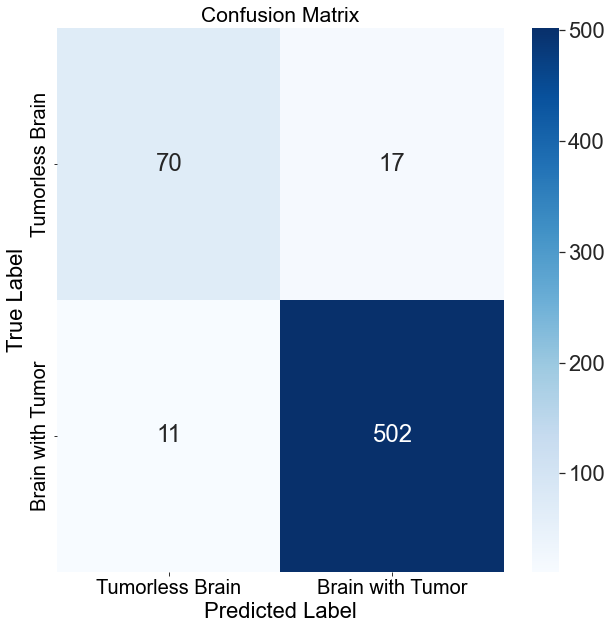

In [16]:
# Evaluating the SVM model by creating a confusion matrix
cm = confusion_matrix(y_val, y_prediction)

plt.figure(figsize=(10,10))
ax = plt.subplot()

sns.set(font_scale=2) 
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g");  

# Labels, title and ticks
label_font = {'size':'22'} 
ax.set_xlabel('Predicted Label', fontdict=label_font);
ax.set_ylabel('True Label', fontdict=label_font);

title_font = {'size':'21'}  
ax.set_title('Confusion Matrix', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=20) 
ax.xaxis.set_ticklabels(['Tumorless Brain', 'Brain with Tumor']);
ax.yaxis.set_ticklabels(['Tumorless Brain', 'Brain with Tumor']);
plt.show()

In [17]:
print("Feature number after HOG: ", hog_X.shape)
print("Feature number after PCA: ", pca_X.shape)

Feature number after HOG:  (3000, 36864)
Feature number after PCA:  (3000, 1519)


## Loading the Test Data

In [18]:
# Defining the folder paths to all images in the test set
basedir2 = './test'
images_dir2 = os.path.join(basedir2,'image')

# Finding the specific path for each image
image_paths2 = [os.path.join(images_dir2, l) for l in os.listdir(images_dir2)]
target_size = None

# Defining the label document
labels_filename = 'label.csv'
# Opening the label document
labels_file2 = open(os.path.join(basedir2, labels_filename), 'r')

# Reading each line of the labels file
lines2 = labels_file2.readlines()

# Splitting the image name and the associated label
tumor_labels2 = {line.split(',')[0] : (line.split(',')[1]) for line in lines2[1:]}

# Changing the labels to binary format by assigning 0 for no_tumor and 1 for brain with tumor
for i in tumor_labels2:
    tumor_labels2[i] = tumor_labels2[i].replace('\n', '')
    if tumor_labels2[i] == "no_tumor":
        tumor_labels2[i] = 0
    else:
        tumor_labels2[i] = 1

# Printing the final labels' format       
print(tumor_labels2)   

# Function for extracting features
def extract_features_labels_test():
    if os.path.isdir(images_dir2):
        all_features = []
        all_labels = []
        for img_path in image_paths2:
            file_name = img_path.split('\\')[-1] # In macOS, change the "\\" to "/"  

            # Loading image and setting the as_gray parameter of imread to True 
            # This way our grayscale image is read as grayscale without RGB channels 
            img = imread(img_path, as_gray = True)
            
            # Reshaping to make sure the images are read correctly 
            features = np.reshape(img, (512,512,1))
            
            # Storing the pixel information in the all_features array
            # and the label information in the all_labels array
            if features is not None:
                all_features.append(features)
                all_labels.append(tumor_labels2[file_name])

    # Converting them to numpy arrays           
    np_features = np.array(all_features)
    np_labels = np.array(all_labels)
    
    return np_features, np_labels

{'IMAGE_0000.jpg': 1, 'IMAGE_0001.jpg': 1, 'IMAGE_0002.jpg': 1, 'IMAGE_0003.jpg': 1, 'IMAGE_0004.jpg': 1, 'IMAGE_0005.jpg': 1, 'IMAGE_0006.jpg': 1, 'IMAGE_0007.jpg': 1, 'IMAGE_0008.jpg': 1, 'IMAGE_0009.jpg': 1, 'IMAGE_0010.jpg': 0, 'IMAGE_0011.jpg': 0, 'IMAGE_0012.jpg': 1, 'IMAGE_0013.jpg': 1, 'IMAGE_0014.jpg': 1, 'IMAGE_0015.jpg': 1, 'IMAGE_0016.jpg': 1, 'IMAGE_0017.jpg': 1, 'IMAGE_0018.jpg': 1, 'IMAGE_0019.jpg': 1, 'IMAGE_0020.jpg': 1, 'IMAGE_0021.jpg': 1, 'IMAGE_0022.jpg': 1, 'IMAGE_0023.jpg': 1, 'IMAGE_0024.jpg': 1, 'IMAGE_0025.jpg': 1, 'IMAGE_0026.jpg': 0, 'IMAGE_0027.jpg': 1, 'IMAGE_0028.jpg': 0, 'IMAGE_0029.jpg': 0, 'IMAGE_0030.jpg': 0, 'IMAGE_0031.jpg': 1, 'IMAGE_0032.jpg': 1, 'IMAGE_0033.jpg': 1, 'IMAGE_0034.jpg': 1, 'IMAGE_0035.jpg': 1, 'IMAGE_0036.jpg': 1, 'IMAGE_0037.jpg': 1, 'IMAGE_0038.jpg': 1, 'IMAGE_0039.jpg': 1, 'IMAGE_0040.jpg': 0, 'IMAGE_0041.jpg': 0, 'IMAGE_0042.jpg': 0, 'IMAGE_0043.jpg': 1, 'IMAGE_0044.jpg': 1, 'IMAGE_0045.jpg': 1, 'IMAGE_0046.jpg': 1, 'IMAGE_0047.

In [19]:
# Calling the function extract_features_labels 
# Storing the image information on x_test and y_test
x_test, y_test = extract_features_labels_test()

## Implementing the Histogram of Oriented Gradients (HOG) Feature Descriptor for the Test Set

In [20]:
# Creating two empty lists for the HOG image and feature information  
hog_visu2 = []
hog_x_test = []

# Converting each image through hog() function
for image in range(len(x_test)):
    x, visu = hog(x_test[image], orientations=9, pixels_per_cell=(8,8),cells_per_block=(1, 1), visualize = True)
    # Adding each HOG image and feature information onto the previously created list
    hog_visu2.append(visu)
    hog_x_test.append(x)

## Implementing the Principal Components Analysis (PCA)

In [21]:
# Scaling the features before implementing PCA to equalize their contribution to variance
#scale.fit(hog_x_test)
scale_x_test = scale.transform(hog_x_test)

# Transforming the test data to the same primary component format found through trainig data
pca_x_test = pca.transform(scale_x_test)

## Predicting the Outputs of the Test Set

In [22]:
y_prediction2 = svm.predict(pca_x_test)

## Evaluating the SVM Model Using the Test Set

In [23]:
# Evaluating the SVM model by determining the accuracy score
print("Accuracy on the test set: " +str(accuracy_score(y_test, y_prediction2)))

Accuracy on the test set: 0.95


In [24]:
# Evaluating the SVM model by creating a classification report
target_names = ['Patient without Tumor', 'Patient with Tumor']
print("Classification report: ", classification_report(y_test, y_prediction2, target_names=target_names))

Classification report:                         precision    recall  f1-score   support

Patient without Tumor       0.97      0.76      0.85        37
   Patient with Tumor       0.95      0.99      0.97       163

             accuracy                           0.95       200
            macro avg       0.96      0.88      0.91       200
         weighted avg       0.95      0.95      0.95       200



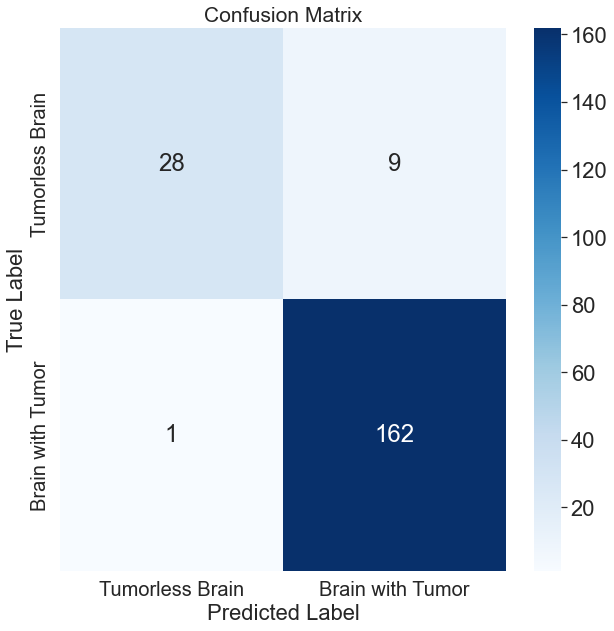

In [25]:
# Evaluating the SVM model by creating a confusion matrix
cm = confusion_matrix(y_test, y_prediction2)

plt.figure(figsize=(10,10))
ax = plt.subplot()

sns.set(font_scale=2) 
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g");  

# Labels, title and ticks
label_font = {'size':'22'} 
ax.set_xlabel('Predicted Label', fontdict=label_font);
ax.set_ylabel('True Label', fontdict=label_font);

title_font = {'size':'21'}  
ax.set_title('Confusion Matrix', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=20) 
ax.xaxis.set_ticklabels(['Tumorless Brain', 'Brain with Tumor']);
ax.yaxis.set_ticklabels(['Tumorless Brain', 'Brain with Tumor']);
plt.show()

In [26]:
# Checking if the feature numbers after HOG and PCA are the same for the test set
print("Feature number after HOG: ", np.array(hog_x_test).shape)
print("Feature number after PCA: ", pca_x_test.shape)

Feature number after HOG:  (200, 36864)
Feature number after PCA:  (200, 1519)
